# **Case Study 1**

**Team**:
- Budurean Marius-Mihai
- Matei Eduard-Andrei
- Gheorghe Luchian-Mihai

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/Datasets/Sign MNIST/'
train_file = path + 'sign_mnist_train.csv'
test_file = path + 'sign_mnist_test.csv'

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

import tensorflow as tf
from keras import layers, models, Model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix


physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.random.set_seed(42)

## **Utilities**

In [7]:
def compare_histories(history1, history2,
                      label1="Model 1", label2="Model 2"):
    """
    Compare training histories of two models in terms of accuracy and loss.
    Shows two plots: one for accuracy, one for loss.
    """
    # Extract data
    acc1 = history1.history["accuracy"]
    val_acc1 = history1.history["val_accuracy"]
    acc2 = history2.history["accuracy"]
    val_acc2 = history2.history["val_accuracy"]

    loss1 = history1.history["loss"]
    val_loss1 = history1.history["val_loss"]
    loss2 = history2.history["loss"]
    val_loss2 = history2.history["val_loss"]

    epochs_1 = range(1, len(acc1) + 1)
    epochs_2 = range(1, len(acc2) + 1)

    # === Accuracy Plot ===
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_1, acc1, color='blue', marker='o', label=f"{label1} Train Accuracy")
    plt.plot(epochs_1, val_acc1, color='skyblue', linestyle='--', marker='x', label=f"{label1} Val Accuracy")
    plt.plot(epochs_2, acc2, color='green', marker='o', label=f"{label2} Train Accuracy")
    plt.plot(epochs_2, val_acc2, color='lightgreen', linestyle='--', marker='x', label=f"{label2} Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Loss Plot ===
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_1, loss1, color='red', marker='o', label=f"{label1} Train Loss")
    plt.plot(epochs_1, val_loss1, color='salmon', linestyle='--', marker='x', label=f"{label1} Val Loss")
    plt.plot(epochs_2, loss2, color='purple', marker='o', label=f"{label2} Train Loss")
    plt.plot(epochs_2, val_loss2, color='orchid', linestyle='--', marker='x', label=f"{label2} Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:
def compare_classification_reports(model1, model2,
                                   model1_name="Model 1",
                                   model2_name="Model 2",
                                   x_test=None, y_test=None,
                                   target_names=None):
    """
    Print and plot classification reports for two models.

    Parameters:
        model1, model2 : Trained Keras models
        model1_name, model2_name : Names for the models
        x_test : Input data
        y_test : One-hot encoded true labels
        target_names : Optional list of class label names
    """
    if x_test is None or y_test is None:
        raise ValueError("x_test and y_test must be provided.")

    y_true_labels = np.argmax(y_test, axis=1)

    # Model 1 predictions
    y_pred1 = np.argmax(model1.predict(x_test, verbose=0), axis=1)
    report1 = classification_report(y_true_labels, y_pred1, output_dict=True, target_names=target_names)
    df1 = pd.DataFrame(report1).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

    # Model 2 predictions
    y_pred2 = np.argmax(model2.predict(x_test, verbose=0), axis=1)
    report2 = classification_report(y_true_labels, y_pred2, output_dict=True, target_names=target_names)
    df2 = pd.DataFrame(report2).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

    print(f"\n=== {model1_name} Classification Report ===")
    print(classification_report(y_true_labels, y_pred1, target_names=target_names))

    print(f"\n=== {model2_name} Classification Report ===")
    print(classification_report(y_true_labels, y_pred2, target_names=target_names))

    # Plot heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    sns.heatmap(df1.iloc[:, :3], annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"{model1_name} Classification Report")
    axes[0].set_ylabel("Class")
    axes[0].set_xlabel("Metric")

    sns.heatmap(df2.iloc[:, :3], annot=True, fmt=".2f", cmap="Greens", ax=axes[1])
    axes[1].set_title(f"{model2_name} Classification Report")
    axes[1].set_ylabel("")
    axes[1].set_xlabel("Metric")

    plt.tight_layout()
    plt.show()

In [9]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           restore_best_weights=True)

## **Dataset Loading and Pre-processing**

Load **CSV** files.

In [12]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

Separate **labels** and **pixel data**.

In [13]:
x_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

x_test = test_df.drop('label', axis=1).values
y_test = test_df['label'].values

Normalize pixel values to **[0, 1]**.

In [14]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Reshape images to **(28, 28, 1)** for CNN input.

In [15]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

Use **One-Hot Encoder** to encode the label class.

In [16]:
# Account for missing 'J' (label 9)
valid_labels = sorted(set(y_train))  # Gets 24 valid values, skips 9
label_mapping = {label: idx for idx, label in enumerate(valid_labels)}

# Apply mapping
y_train = np.array([label_mapping[y] for y in y_train])
y_test = np.array([label_mapping[y] for y in y_test])

# One-hot encode after split
num_classes = len(label_mapping)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

Output shapes check.

In [17]:
print(f"Train: {x_train.shape}, {y_train.shape}")
print(f"Test:  {x_test.shape}, {y_test.shape}")

Train: (27455, 28, 28, 1), (27455, 24)
Test:  (7172, 28, 28, 1), (7172, 24)


## **Network in Network (NiN)**

### **Utilities**

Define the **NiN Block**.

In [18]:
def nin_block(num_channels, kernel_size=3, strides=1, padding='same'):
    """
    A NiN block: Conv -> 1x1 Conv -> 1x1 Conv with ReLU activations.
    """
    def block(x):
        x = layers.Conv2D(num_channels, kernel_size,
                          strides=strides, padding=padding,
                          activation='relu')(x)
        x = layers.Conv2D(num_channels, kernel_size=1, activation='relu')(x)
        x = layers.Conv2D(num_channels, kernel_size=1, activation='relu')(x)
        return x
    return block

Construct the **NiN Model**.

In [19]:
def build_nin_model(input_shape, num_classes,
                    channels=(64, 64, 128),
                    dropout_rates=(0.2, 0.2, 0.3),
                    final_dense=128,
                    final_dropout=0.4):
    """
    Construct a NiN model suitable for smaller images (e.g. 28x28).

    Args:
        input_shape : (height, width, channels), e.g. (28, 28, 1)
        num_classes : number of output classes
        channels    : tuple of channel sizes for each NiN block
                      (3 blocks shown by default).
        dropout_rates : tuple of dropout after each pool (for the first 2 blocks)
                        + one after third block (or adjust as needed).
        final_dense : units in the final Dense layer after global pooling
        final_dropout : dropout used right before the output layer
    """

    inputs = layers.Input(shape=input_shape)

    # 1) First NiN block
    x = nin_block(channels[0], kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    x = layers.Dropout(dropout_rates[0])(x)

    # 2) Second NiN block
    x = nin_block(channels[1], kernel_size=3, strides=1, padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    x = layers.Dropout(dropout_rates[1])(x)

    # 3) Third NiN block
    x = nin_block(channels[2], kernel_size=3, strides=1, padding='same')(x)
    x = layers.Dropout(dropout_rates[2])(x)

    # Global Average Pool transforms (H, W, Channels) -> (Channels,)
    x = layers.GlobalAveragePooling2D()(x)

    # Optional Dense + Dropout before final output
    x = layers.Dense(final_dense, activation='relu')(x)
    x = layers.Dropout(final_dropout)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

### **Model**

**Compile** the model.

In [20]:
nin = build_nin_model(input_shape=(28, 28, 1), num_classes=24)
nin.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


**Train** the model.

In [21]:
history_nin = nin.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[early_stop])


Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 30s 91ms/step - accuracy: 0.0447 - loss: 3.1728 - val_accuracy: 0.0896 - val_loss: 3.0159
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1041 - loss: 2.9031 - val_accuracy: 0.2091 - val_loss: 2.2800
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2077 - loss: 2.3277 - val_accuracy: 0.3704 - val_loss: 1.8001
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3430 - loss: 1.8374 - val_accuracy: 0.6157 - val_loss: 1.1036
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5282 - loss: 1.2285 - val_accuracy: 0.7381 - val_loss: 0.7335
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6594 - loss: 0.8437 - val_accuracy: 0.8405 - val_loss: 0.4369
Epoch 7/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7533 - loss: 0.6137 - val_accuracy: 0.8942 - val_loss: 0.2791
Epoch 8/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8078 - loss: 0.4889 - val_acc

## **Multi-Batch Networks (GoogLeNet)**

### Utilities

Define the **Inception Block**.

In [22]:
def inception_block(x,
                    filters_1,
                    filters_3_reduce, filters_3,
                    filters_5_reduce, filters_5,
                    filters_pool):
    """
    A simplified Inception block with 4 branches:
      1) 1x1 conv
      2) 1x1 conv -> 3x3 conv
      3) 1x1 conv -> 5x5 conv
      4) 3x3 maxpool -> 1x1 conv
    Then concat along the channel dimension.

    Args:
        x: Input tensor.
        filters_1:    # channels for the 1x1 branch
        filters_3_reduce, filters_3:
                      # channels for the 1x1->3x3 branch
        filters_5_reduce, filters_5:
                      # channels for the 1x1->5x5 branch
        filters_pool: # channels for the pool->1x1 branch
    """
    # Branch 1: 1x1 conv
    branch1 = layers.Conv2D(filters_1, kernel_size=1, activation='relu')(x)

    # Branch 2: 1x1 conv -> 3x3 conv
    branch2 = layers.Conv2D(filters_3_reduce, kernel_size=1, activation='relu')(x)
    branch2 = layers.Conv2D(filters_3, kernel_size=3, padding='same', activation='relu')(branch2)

    # Branch 3: 1x1 conv -> 5x5 conv
    branch3 = layers.Conv2D(filters_5_reduce, kernel_size=1, activation='relu')(x)
    branch3 = layers.Conv2D(filters_5, kernel_size=5, padding='same', activation='relu')(branch3)

    # Branch 4: 3x3 max pool -> 1x1 conv
    branch4 = layers.MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    branch4 = layers.Conv2D(filters_pool, kernel_size=1, activation='relu')(branch4)

    # Concatenate all branches along channels
    x = layers.Concatenate(axis=-1)([branch1, branch2, branch3, branch4])
    return x

Construct the **Multi-Branch Model**.

In [23]:
def build_googlenet(input_shape, num_classes):
    """
    Build a simplified GoogLeNet for 28x28 images.

    1) A small initial Conv + pool
    2) Two Inception blocks + pool
    3) One more Inception block
    4) Global average pool + Dense -> softmax

    Scaled down from typical GoogLeNet for big images.
    """
    inputs = layers.Input(shape=input_shape)

    # Initial small conv block
    x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)  # 14x14 after this

    # Inception block 1 (numbers are scaled down)
    x = inception_block(x, 16, 16, 24, 4, 8, 8)
    # Inception block 2
    x = inception_block(x, 24, 24, 32, 8, 8, 8)
    # Another pool
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)  # 7x7 after this

    # Inception block 3
    x = inception_block(x, 24, 24, 32, 8, 8, 8)

    # Global Average Pool across the 7x7 spatial dimensions -> (channels)
    x = layers.GlobalAveragePooling2D()(x)

    # Optional Dense for final features
    x = layers.Dense(64, activation='relu')(x)
    # Optionally add dropout if needed
    x = layers.Dropout(0.3)(x)

    # Final classification output
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

### **Model**

**Compile** the model.

In [24]:
googlenet = build_googlenet(input_shape=(28,28,1), num_classes=24)

googlenet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Train** the model.

In [25]:
history_googlenet = googlenet.fit(x_train, y_train,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=128,
                    shuffle=True,
                    callbacks=[early_stop])

Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.0538 - loss: 3.1660 - val_accuracy: 0.1441 - val_loss: 2.8545
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1872 - loss: 2.5840 - val_accuracy: 0.4263 - val_loss: 1.7690
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3447 - loss: 1.8828 - val_accuracy: 0.5389 - val_loss: 1.3874
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4553 - loss: 1.5253 - val_accuracy: 0.5992 - val_loss: 1.1657
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5390 - loss: 1.2661 - val_accuracy: 0.6736 - val_loss: 0.9453
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6046 - loss: 1.0642 - val_accuracy: 0.7665 - val_loss: 0.7071
Epoch 7/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6677 - loss: 0.8985 - val_accuracy: 0.7988 - val_loss: 0.5997
Epoch 8/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7099 - loss: 0.7728 - val_accuracy

## **Comparison**

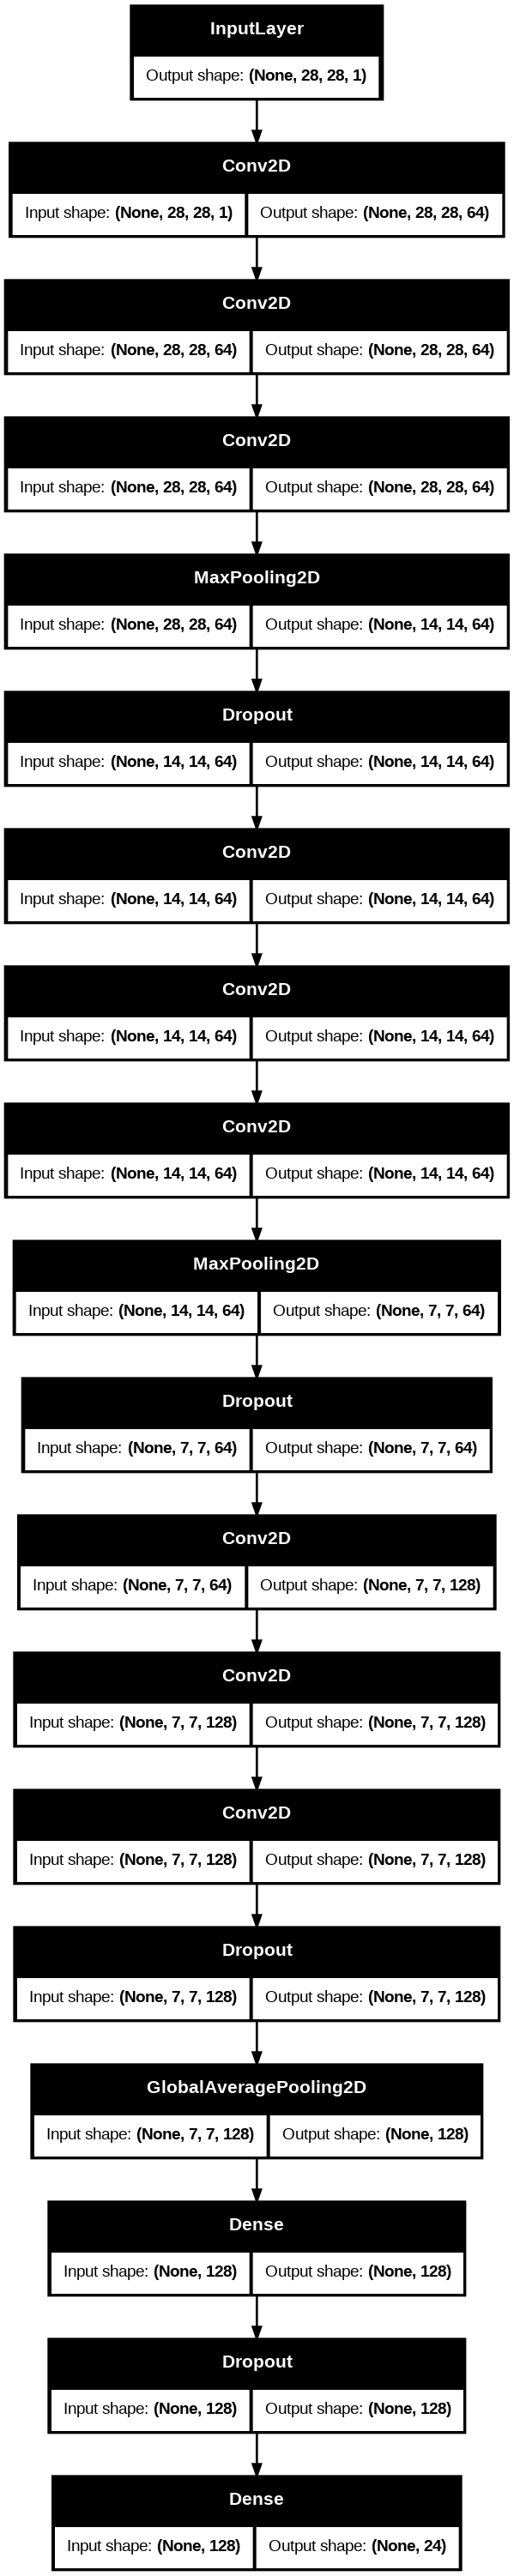

In [26]:
plot_model(nin, to_file="nin.png", show_shapes=True, dpi=96)
Image("nin.png")

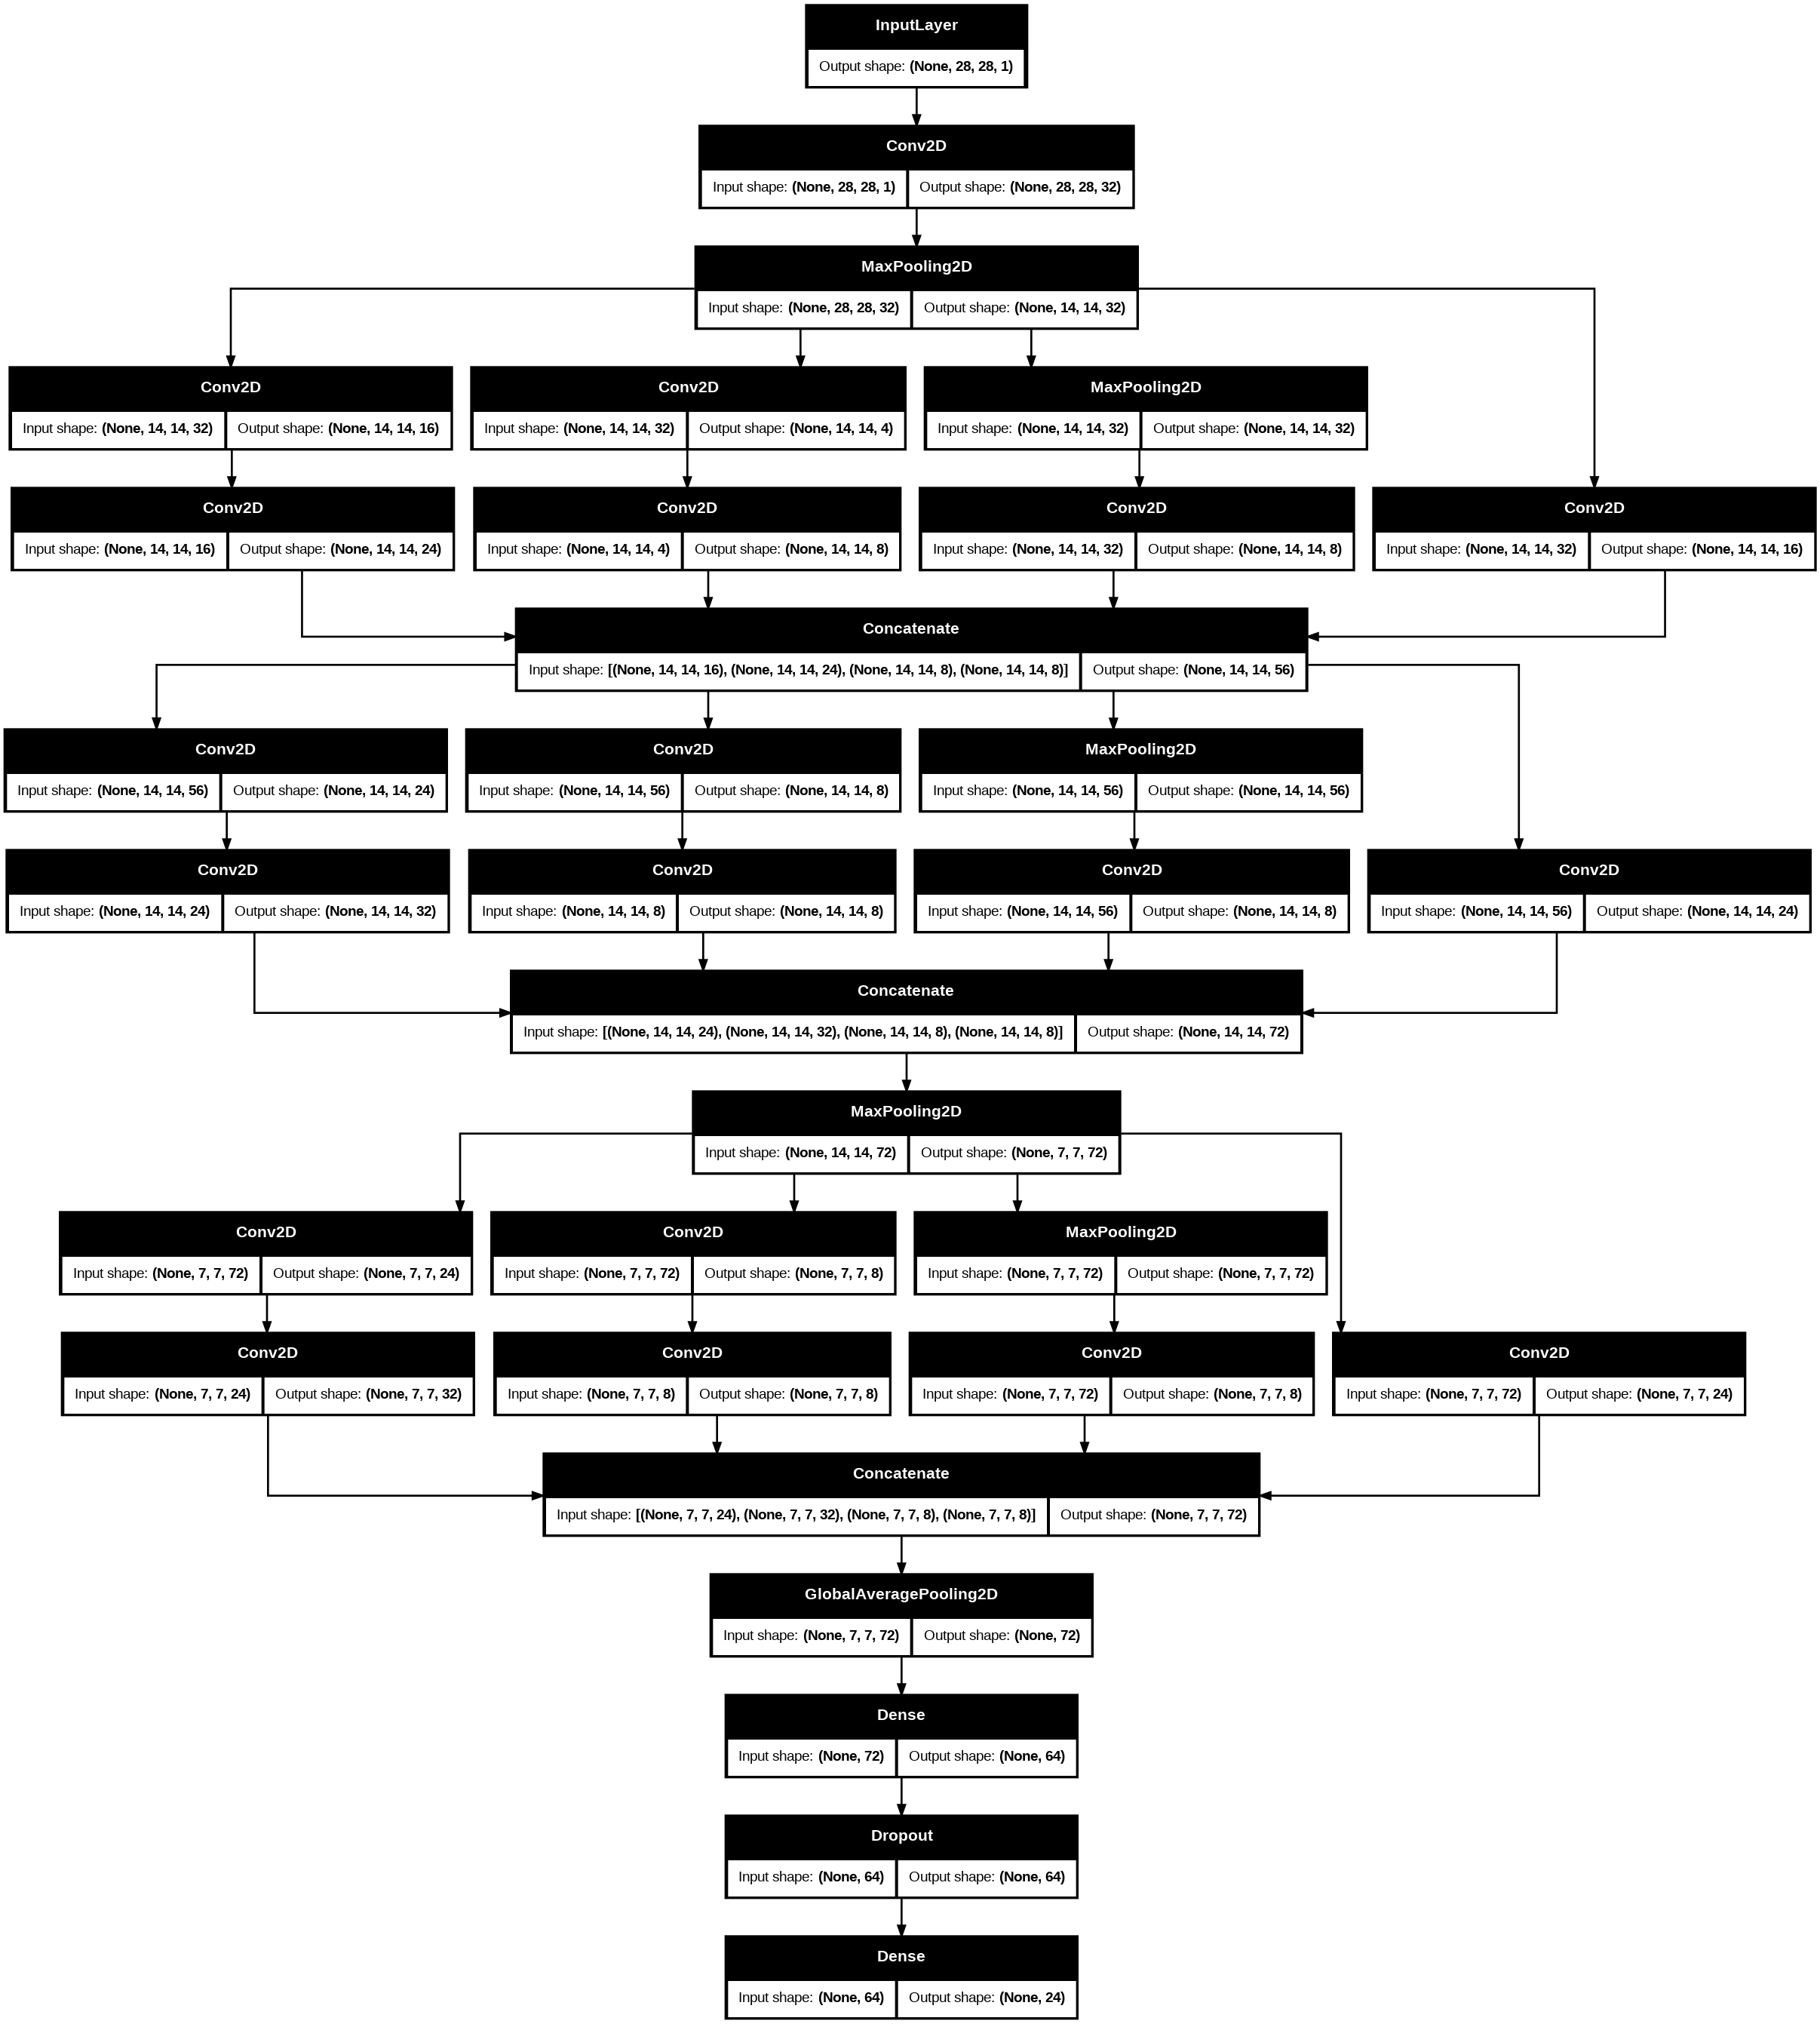

In [27]:
plot_model(googlenet, to_file="googlenet.png", show_shapes=True, dpi=96)
Image("googlenet.png")

In [28]:
test_loss_nin, test_acc_nin = nin.evaluate(x_test, y_test, verbose=0)
test_loss_googlenet, test_acc_googlenet = googlenet.evaluate(x_test, y_test, verbose=0)

params_nin = nin.count_params()
params_googlenet = googlenet.count_params()

data = {
    "Model": ["NiN", "GoogLeNet"],
    "Loss": [test_loss_nin, test_loss_googlenet],
    "Accuracy": [test_acc_nin, test_acc_googlenet],
    "Params": [params_nin, params_googlenet]
}

df_summary = pd.DataFrame(data)
print(df_summary)

       Model      Loss  Accuracy  Params
0        NiN  0.053941  0.983687  180696
1  GoogLeNet  0.192581  0.936141   37716


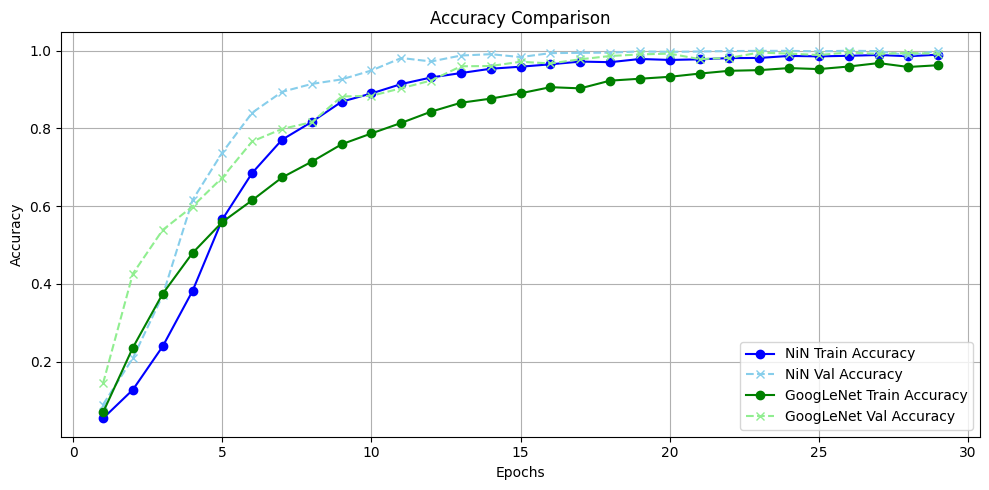

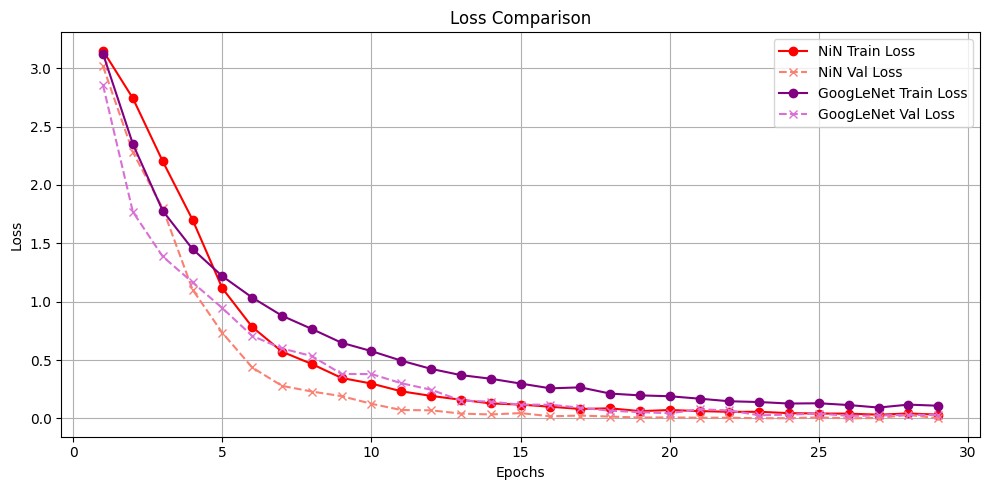

In [29]:
compare_histories(history_nin, history_googlenet,
                  label1="NiN",
                  label2="GoogLeNet")


=== NiN Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      0.95      0.98       498
           5       1.00      1.00      1.00       247
           6       0.86      1.00      0.93       348
           7       1.00      0.92      0.96       436
           8       1.00      0.99      1.00       288
           9       1.00      0.96      0.98       331
          10       1.00      1.00      1.00       209
          11       0.96      0.98      0.97       394
          12       1.00      0.95      0.97       291
          13       0.99      1.00      0.99       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       0.92      1.00      0.96   

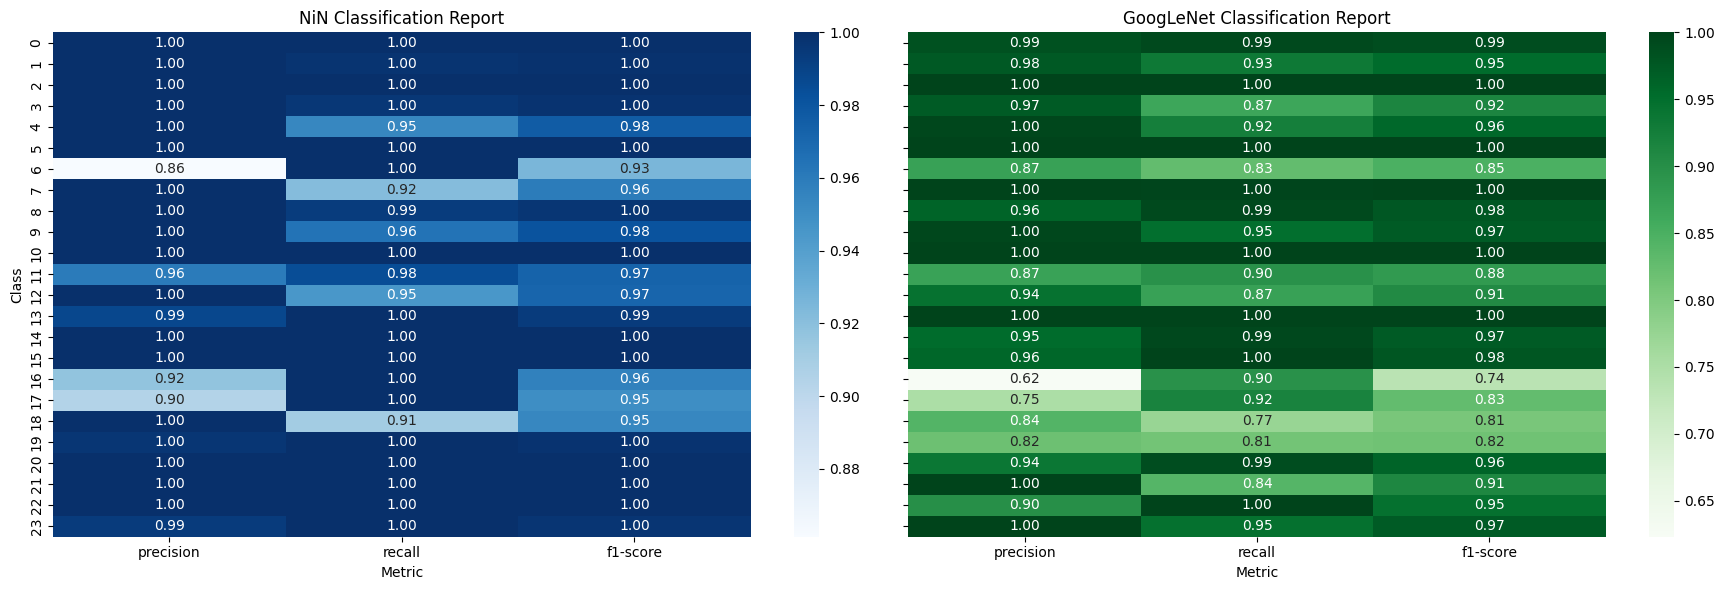

In [30]:
compare_classification_reports(
    model1=nin,
    model2=googlenet,
    model1_name="NiN",
    model2_name="GoogLeNet",
    x_test=x_test,
    y_test=y_test
)


## **Transfer Learning MNIST**


### **Dataset Pre-processing**

In [32]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = mnist.load_data()

# Normalize pixel values to [0, 1]
x_mnist_train = x_mnist_train.astype("float32") / 255.0
x_mnist_test = x_mnist_test.astype("float32") / 255.0

# Reshape to (28, 28, 1)
x_mnist_train = np.expand_dims(x_mnist_train, axis=-1)
x_mnist_test = np.expand_dims(x_mnist_test, axis=-1)

# One-hot encode labels (10 classes for digits 0–9)
y_mnist_train = to_categorical(y_mnist_train, num_classes=10)
y_mnist_test = to_categorical(y_mnist_test, num_classes=10)

# Show shapes to verify
print("Train:", x_mnist_train.shape, y_mnist_train.shape)
print("Test:", x_mnist_test.shape, y_mnist_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Train: (60000, 28, 28, 1) (60000, 10)
Test: (10000, 28, 28, 1) (10000, 10)


### **Network in Network**

In [35]:
for layer in nin.layers:
    layer.trainable = False

x = nin.layers[-2].output  # dense layer before softmax
new_output_nin = layers.Dense(10, activation='softmax')(x)  # MNIST has 10 digits
transfer_nin = Model(inputs=nin.input, outputs=new_output_nin)

transfer_nin.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

history_transfer_nin = transfer_nin.fit(
    x_mnist_train, y_mnist_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    shuffle=True,
    callbacks=[early_stop])

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.1962 - loss: 6.8113 - val_accuracy: 0.5475 - val_loss: 1.3261
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3835 - loss: 1.8856 - val_accuracy: 0.5611 - val_loss: 1.3050
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4367 - loss: 1.5972 - val_accuracy: 0.5633 - val_loss: 1.3005
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4458 - loss: 1.5638 - val_accuracy: 0.5742 - val_loss: 1.2967
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4473 - loss: 1.5630 - val_accuracy: 0.5702 - val_loss: 1.2928
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4493 - loss: 1.5628 - val_accuracy: 0.5652 - val_loss: 1.2914
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4505 - loss: 1.5527 - val_accuracy: 0.5791 - val_loss: 1.2835
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4513 - loss: 1.5550 - val_accuracy: 0

In [41]:
for layer in nin.layers:
    layer.trainable = False

x = nin.layers[-2].output
new_output_nin = layers.Dense(10, activation='softmax')(x)
transfer_nin = Model(inputs=nin.input, outputs=new_output_nin)

for layer in transfer_nin.layers[-5:]:
    layer.trainable = True

transfer_nin.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

history_transfer_nin = transfer_nin.fit(
    x_mnist_train, y_mnist_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    shuffle=True,
    callbacks=[early_stop])


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.2659 - loss: 3.7598 - val_accuracy: 0.5921 - val_loss: 1.2289
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4847 - loss: 1.4619 - val_accuracy: 0.6459 - val_loss: 1.0731
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5436 - loss: 1.3170 - val_accuracy: 0.6968 - val_loss: 0.9589
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5704 - loss: 1.2333 - val_accuracy: 0.7190 - val_loss: 0.9148
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5942 - loss: 1.1684 - val_accuracy: 0.7425 - val_loss: 0.8502
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6112 - loss: 1.1311 - val_accuracy: 0.7610 - val_loss: 0.8091
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6288 - loss: 1.0909 - val_accuracy: 0.7727 - val_loss: 0.7705
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6348 - loss: 1.0676 - val_accuracy: 0.

### **Multi-Branch Network**

In [36]:
for layer in googlenet.layers:
    layer.trainable = False

x = googlenet.layers[-2].output

new_output = layers.Dense(10, activation='softmax')(x)

transfer_googlenet = Model(inputs=googlenet.input, outputs=new_output)

transfer_googlenet.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

history_transfer_googlenet = transfer_googlenet.fit(
    x_mnist_train, y_mnist_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    shuffle=True,
    callbacks=[early_stop])

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.1503 - loss: 7.8215 - val_accuracy: 0.5220 - val_loss: 1.3628
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3958 - loss: 1.8427 - val_accuracy: 0.6312 - val_loss: 1.1597
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4936 - loss: 1.4288 - val_accuracy: 0.6459 - val_loss: 1.1330
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5018 - loss: 1.4033 - val_accuracy: 0.6417 - val_loss: 1.1274
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5050 - loss: 1.3910 - val_accuracy: 0.6526 - val_loss: 1.1122
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5080 - loss: 1.3868 - val_accuracy: 0.6453 - val_loss: 1.1099
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5096 - loss: 1.3816 - val_accuracy: 0.6523 - val_loss: 1.1017
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5050 - loss: 1.3867 - val_accuracy: 0

In [43]:
for layer in googlenet.layers:
    layer.trainable = False

x = googlenet.layers[-2].output
new_output_goog = layers.Dense(10, activation='softmax')(x)
transfer_googlenet = Model(inputs=googlenet.input, outputs=new_output_goog)

for layer in transfer_googlenet.layers[-5:]:
    layer.trainable = True

transfer_googlenet.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

history_transfer_googlenet = transfer_googlenet.fit(
    x_mnist_train, y_mnist_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    shuffle=True,
    callbacks=[early_stop])

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2632 - loss: 4.1092 - val_accuracy: 0.6432 - val_loss: 1.1426
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5421 - loss: 1.2998 - val_accuracy: 0.7441 - val_loss: 0.8475
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6179 - loss: 1.0886 - val_accuracy: 0.7900 - val_loss: 0.6832
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6646 - loss: 0.9681 - val_accuracy: 0.8233 - val_loss: 0.5907
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7069 - loss: 0.8677 - val_accuracy: 0.8387 - val_loss: 0.5467
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7314 - loss: 0.7941 - val_accuracy: 0.8550 - val_loss: 0.4870
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7538 - loss: 0.7363 - val_accuracy: 0.8596 - val_loss: 0.4581
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7706 - loss: 0.6877 - val_accuracy: 0.

### **Comparison**

In [44]:
test_loss_transfer_nin, test_acc_transfer_nin = transfer_nin.evaluate(x_mnist_test, y_mnist_test, verbose=0)
test_loss_transfer_googlenet, test_acc_transfer_googlenet = transfer_googlenet.evaluate(x_mnist_test, y_mnist_test, verbose=0)

# Count parameters (total trainable + frozen)
params_transfer_nin = transfer_nin.count_params()
params_transfer_googlenet = transfer_googlenet.count_params()

# Build comparison table
data_transfer = {
    "Model": ["NiN (Transfer)", "GoogLeNet (Transfer)"],
    "Loss": [test_loss_transfer_nin, test_loss_transfer_googlenet],
    "Accuracy": [test_acc_transfer_nin, test_acc_transfer_googlenet],
    "Params": [params_transfer_nin, params_transfer_googlenet]
}

df_transfer_summary = pd.DataFrame(data_transfer)
print(df_transfer_summary)

                  Model      Loss  Accuracy  Params
0        NiN (Transfer)  0.581377    0.8288  178890
1  GoogLeNet (Transfer)  0.238773    0.9264   36806


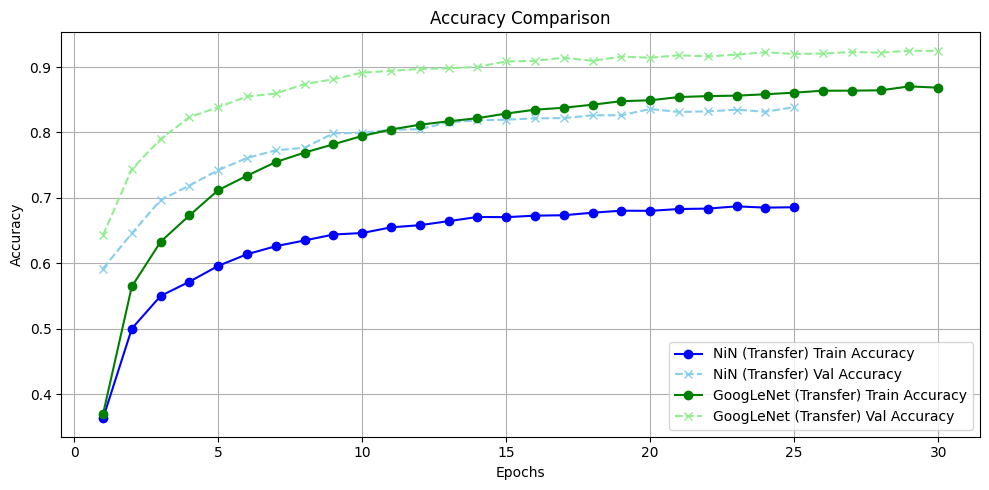

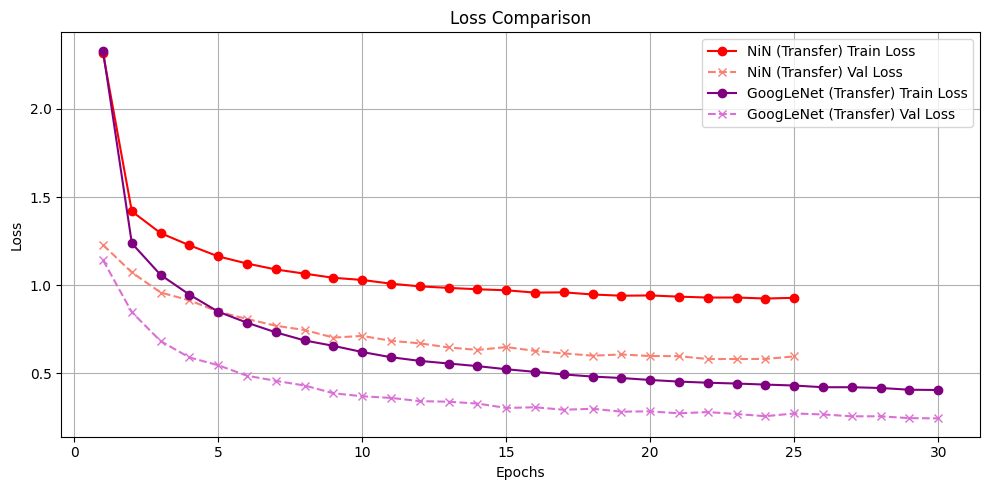

In [45]:
compare_histories(history_transfer_nin, history_transfer_googlenet,
                  label1="NiN (Transfer)",
                  label2="GoogLeNet (Transfer)")



=== NiN (Transfer) Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       980
           1       0.97      0.99      0.98      1135
           2       0.82      0.71      0.76      1032
           3       0.67      0.86      0.75      1010
           4       0.88      0.83      0.86       982
           5       0.78      0.68      0.73       892
           6       0.78      0.88      0.83       958
           7       0.88      0.85      0.86      1028
           8       0.83      0.76      0.79       974
           9       0.81      0.76      0.79      1009

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000


=== GoogLeNet (Transfer) Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       980
           1       0.98      0.99 

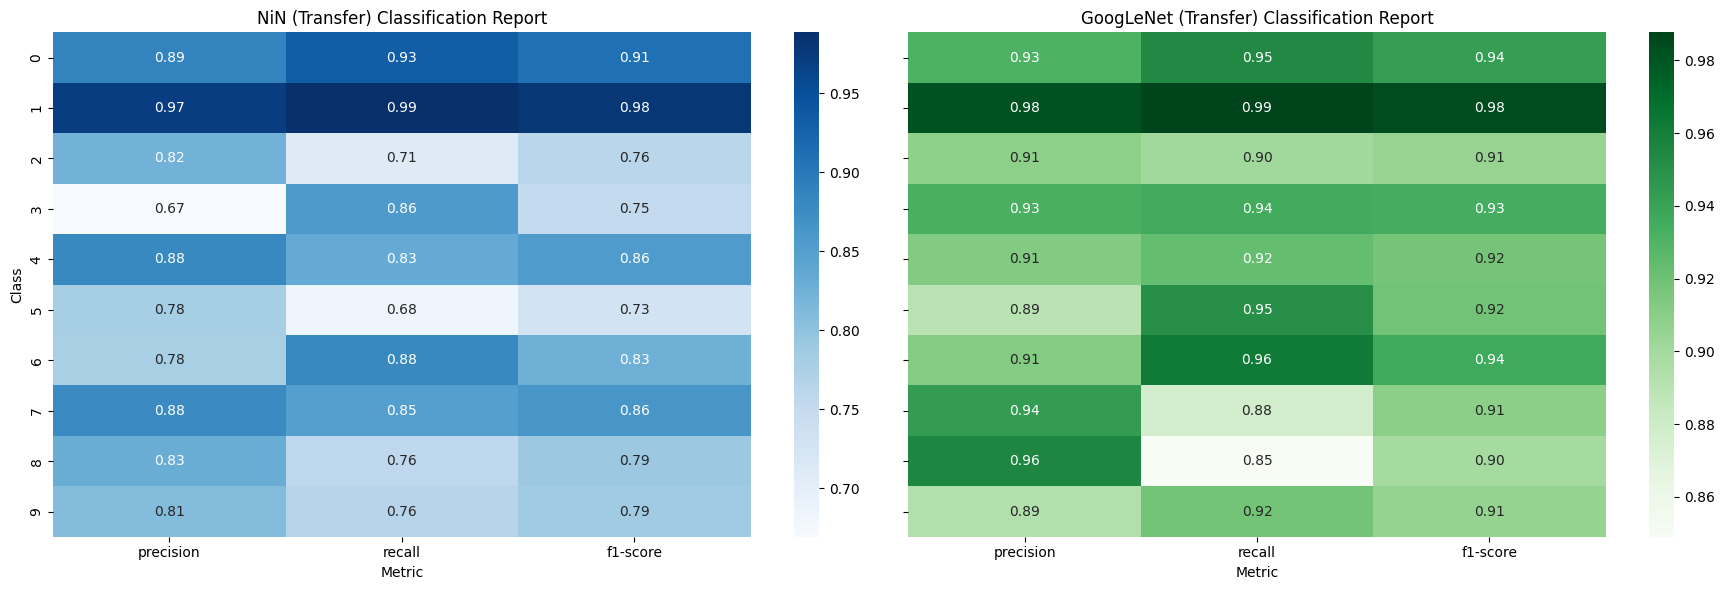

In [46]:
compare_classification_reports(
    model1=transfer_nin,
    model2=transfer_googlenet,
    model1_name="NiN (Transfer)",
    model2_name="GoogLeNet (Transfer)",
    x_test=x_mnist_test,
    y_test=y_mnist_test,
    target_names=[str(i) for i in range(10)]  # digits 0–9
)